### **Premier rendu : Build a TF-IDF Matrix**

In [ ]:
#Installing packages for all exercises:

import numpy as np 
import pandas as pd
import nltk
import re
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings("ignore") # avoids seeing persistent warnings in a block or pandas informing us that it 
                                    # will no longer be possible in a future version to fill a dataframe with Nans or without 
                                    # a previously defined value

nltk.download('punkt_tab')

In [66]:
#download product data  
tf_idf = pd.read_csv('tf_idf.csv')
tf_idf

,product_name
0,medela - creme d'allaitement a la lanoline med...
1,serviette hygienique doulys - ultra - special ...
2,auchan mozzarella en boule
3,pantalon chino le pantalon ( taille 36 )
4,cordon de telephone - tresse - gris argent
...,...
9335,world of cyberpunk 2077 : ta voix
9336,claquette adilette shower
9337,vin rouge a.o.p. alsace pinot noir la cave d'a...
9338,yaourt a boire actimel - multifruits - 8x100g


#### **1) Data préparation et feature engenering** 
- Remove punctuation and special characters (use regex)
- Get rid of numbers (use regex)
- Remove words which have less than 3 letters
- tokenize data

In [ ]:
def remove_words_inf_3(text):
    # Function to remove words with fewer than 3 letters 
    words = text.split() # Identify each word in a product
    filtered_words = [word for word in words if len(word) >= 3] # Loop through each word retrieved to filter out those with fewer than 3 characters
    return ' '.join(filtered_words) # Return a character string containing only the words that passed the filter

tf_idf['product_name'] = tf_idf['product_name'].str.replace(r'[^\w\s]', '', regex=True) # Remove punctuation 
tf_idf['product_name'] = tf_idf['product_name'].str.replace(r'\d+', '', regex=True) # We remove the numbers
tf_idf['product_name'] = tf_idf['product_name'].apply(remove_words_inf_3) # Remove 3-letter words from misn

tf_idf

,product_name
0,medela creme dallaitement lanoline medela pure...
1,serviette hygienique doulys ultra special nuit
2,auchan mozzarella boule
3,pantalon chino pantalon taille
4,cordon telephone tresse gris argent
...,...
9335,world cyberpunk voix
9336,claquette adilette shower
9337,vin rouge aop alsace pinot noir cave daugustin...
9338,yaourt boire actimel multifruits


In [70]:
# We use word_tokenize on a single line to test the behavior.
texte_test = tf_idf['product_name'].iloc[0]
tokens = word_tokenize(texte_test)
tokens

['medela',
 'creme',
 'dallaitement',
 'lanoline',
 'medela',
 'purelan',
 'mamelons',
 'douloureux',
 'peaux',
 'seches',
 'naturelle',
 'hypoallergenique']

In [71]:
# We apply the tokenization function to all products in the list, which will give us a list of words for each product. 
# This means we get one token per product. PLEASE note: we will need to manage duplicates for TF and IDF later on.

tf_idf['tokens'] = tf_idf['product_name'].apply(word_tokenize)
tf_idf.head()

,product_name,tokens
0,medela creme dallaitement lanoline medela pure...,"[medela, creme, dallaitement, lanoline, medela..."
1,serviette hygienique doulys ultra special nuit,"[serviette, hygienique, doulys, ultra, special..."
2,auchan mozzarella boule,"[auchan, mozzarella, boule]"
3,pantalon chino pantalon taille,"[pantalon, chino, pantalon, taille]"
4,cordon telephone tresse gris argent,"[cordon, telephone, tresse, gris, argent]"


### **2) Creation des matrices TF et IDF** 
- Construction de l'IDF 
- Construction du TF grace au colonnes d'IDF qui contient déjà les token unique sans doublons


##### **1) IDF**

In [ ]:
# Calculation of N = number of documents (here, number of lines) 
N = tf_idf.shape[0]
print(f'Nombre de ligne : {N}')

idf_idf_matrix = {}# Create a dictionary that will be dynamically populated and then converted into a dataframe.

for i in range(N): # for each product 
    unique_words = set(tf_idf.loc[i, 'tokens'])  # We retrieve the list of unique words per product.
    for j in unique_words: # we loop on each of these words 
        if j in idf_idf_matrix: # We check if it has already been added to the dictionary. 
            idf_idf_matrix[j] += 1 # if yes, then add 1 to the count 
        else:
            idf_idf_matrix[j] = 1 #otherwise, create and set to 1 the number of occurrences across documents

idf_idf_matrix = pd.DataFrame([idf_idf_matrix]) # We convert it into a Dataframe using pandas. 
idf_idf_matrix = np.log(N / idf_idf_matrix) # We apply the formula of the log of the number of lines / the value of each vase in the IDF. 

idf_idf_matrix

Nombre de ligne : 9340


,hypoallergenique,mamelons,peaux,seches,naturelle,dallaitement,douloureux,medela,lanoline,creme,...,merino,stripes,shockproof,jujutsu,kaisen,gojo,satoru,voix,cyberpunk,claquette
0,7.06262,9.142062,6.434011,7.350302,5.504475,7.532624,9.142062,9.142062,9.142062,3.943564,...,9.142062,9.142062,9.142062,9.142062,9.142062,9.142062,9.142062,9.142062,9.142062,9.142062


##### **2) TF**

In [76]:
def create_tf_matrix_binary(df, tokens, product_col='product_name'):
    # From a list of tokens and a product dataset 
    tf_matrix = pd.DataFrame(index=df.index) # create a data set from the document list 
    tf_matrix[product_col] = df[product_col] # we create as many columns as there are tokens we obtain a matrix with dimensions document * tokens 
    
    # For each token, check for presence (0 or 1)
    for token in tokens:
        tf_matrix[token] = df[product_col].str.lower().str.contains(
            token.lower(), # to avoid problems with capital letters, write everything in lowercase
            regex=False,
            na=False
        ).astype(int) # Converting a boolean to an int is equivalent to having 0-1 instead of False-True. 

    return tf_matrix

tokens = [col for col in idf_idf_matrix.columns if col != 'product_name'] # Retrieve tokens from the list of IDF columns
tf_matrix = create_tf_matrix_binary(tf_idf, tokens)

tf_matrix.head(5)

,product_name,hypoallergenique,mamelons,peaux,seches,naturelle,dallaitement,douloureux,medela,lanoline,...,merino,stripes,shockproof,jujutsu,kaisen,gojo,satoru,voix,cyberpunk,claquette
0,medela creme dallaitement lanoline medela pure...,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,serviette hygienique doulys ultra special nuit,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,auchan mozzarella boule,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pantalon chino pantalon taille,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,cordon telephone tresse gris argent,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9335,world cyberpunk voix,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
9336,claquette adilette shower,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9337,vin rouge aop alsace pinot noir cave daugustin...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9338,yaourt boire actimel multifruits,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### **2) TF-IDF Matrix**

In [77]:
# Direct multiplication
# Extract only the token columns (without product_name)
tf_values = tf_matrix.drop(columns=['product_name'])
idf_values = idf_idf_matrix

# Multiply TF * IDF
#  IDF is a vector (a single line), so we take the first line
tfidf_values = tf_values * idf_values.iloc[0]

# Recreate the DataFrame with product_name
tfidf_matrix = pd.concat([
    tf_matrix[['product_name']], #We concatenate the product name column with the TF IDF value matrix we just created.
    tfidf_values
], axis=1)

tfidf_matrix.head(5)

,product_name,hypoallergenique,mamelons,peaux,seches,naturelle,dallaitement,douloureux,medela,lanoline,...,merino,stripes,shockproof,jujutsu,kaisen,gojo,satoru,voix,cyberpunk,claquette
0,medela creme dallaitement lanoline medela pure...,7.06262,9.142062,6.434011,7.350302,5.504475,7.532624,9.142062,9.142062,9.142062,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,serviette hygienique doulys ultra special nuit,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,auchan mozzarella boule,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,pantalon chino pantalon taille,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,cordon telephone tresse gris argent,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9335,world cyberpunk voix,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.142062,9.142062,0.000000
9336,claquette adilette shower,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,9.142062
9337,vin rouge aop alsace pinot noir cave daugustin...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
9338,yaourt boire actimel multifruits,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


### **Part 2 :  Using the cosine similarity and you tf-idf matrix, find the closest products of the following ones :**

**panatalon noir, balai essuie glaces avant, fromage fondu kiri, lentilles 265g, croutons à l'ail tipiak, mozarella bille 150g, sac a bandouillere en nylon, mais doux saint eloi, croustibat findus, pipe rigate carrefour**


In [79]:
# We retrieve the different products from the list split at each comma. 

text = ["panatalon noir, balai essuie glaces avant, fromage fondu kiri, lentilles 265g, croutons à l'ail tipiak, mozarella bille 150g, sac a bandouillere en nylon, mais doux saint eloi, croustibat findus, pipe rigate carrefour"]
list = text[0].split(',')

# Convert the list to a dataframe with a single column
product=pd.DataFrame(list)
product.rename(columns={0: 'product_name'}, inplace=True)

# Same data preparation as in exercise 1 

product['product_name'] = product['product_name'].str.replace(r'[^\w\s]', '', regex=True)
product['product_name'] = product['product_name'].str.replace(r'\d+', '', regex=True)
product['product_name'] = product['product_name'].apply(remove_words_inf_3)

product

,product_name
0,panatalon noir
1,balai essuie glaces avant
2,fromage fondu kiri
3,lentilles
4,croutons lail tipiak
5,mozarella bille
6,sac bandouillere nylon
7,mais doux saint eloi
8,croustibat findus
9,pipe rigate carrefour


In [83]:
def create_embeddings(df, idf_matrix):
    # Definition of a function to create embeddings (vector form) for a given product 
    for i in range(df.shape[0]):
        # Retrieve tokens from line i specifically (understood to mean each product)
        product_tokens = df.loc[i, 'product_name'].lower().split()
        
        # For each column in the idf data set (also works with tf or tf-idf), i.e., each token known to our database
        for k in df.columns:
            if k == 'product_name': # The product name column is not a token, so we skip it. 
                continue
            
            # If token k is in the product, then we associate it with the value of the token from IDF. 
            if k.lower() in product_tokens:
                df.loc[i, k] = idf_matrix.at[0, k]
            
    df.fillna(0.0, inplace=True) # Ensure that the dimensions of the embedding vector that do not have an assigned value are set to 0 
    return df

embeddings = pd.concat([product, idf_idf_matrix], ignore_index=True) # We construct the embedding matrix as a sequence 
                                                                     # of vector number representing each product according to our IDF
embeddings = embeddings.iloc[:-1, :] #We're just cleaning up the matrix because with the concat we got a good-sized matrix and 
                                    #the label for each token in our occlusion, but it added an extra line with the 
                                    #IDF values, so we're removing it
embeddings = create_embeddings(embeddings, idf_idf_matrix)
embeddings

,product_name,hypoallergenique,mamelons,peaux,seches,naturelle,dallaitement,douloureux,medela,lanoline,...,merino,stripes,shockproof,jujutsu,kaisen,gojo,satoru,voix,cyberpunk,claquette
0,panatalon noir,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,balai essuie glaces avant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,fromage fondu kiri,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,lentilles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,croutons lail tipiak,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,mozarella bille,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,sac bandouillere nylon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,mais doux saint eloi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,croustibat findus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,pipe rigate carrefour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Premier test de calcul de cosine similarité pour mesurer la distance entre deux représentation vectoriel de produit

In [82]:
def cosine_similarity(vec1, vec2):
    """Compare deux vecteurs de dimension (1,embeddings.shape[1])"""
    vec1 = np.array(vec1)# On convertie les vecteurs en array numpy 
    vec2 = np.array(vec2)
    
    dot_product = np.dot(vec1, vec2) # on applique un produit scalaire entre les duex vecteur de meme dimension 
    norm_vec1 = np.linalg.norm(vec1) # on mesure  la norme de chaque vecteur 
    norm_vec2 = np.linalg.norm(vec2)
    
    # évite la division par zéro
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0.0
    
    return dot_product / (norm_vec1 * norm_vec2) # on calcul la le cosinus avec le ratio entre produt sclaire te le produit des norme

def find_most_similar_products(query_vector, df):
    """
    Compare un vecteur avec tous les vecteurs dans df
    
    Args:
        query_vector: Series ou array - UN vecteur (sans product_name)
        df: DataFrame - base de référence avec product_name + features
    """
    liste_most_similar = [] # Create a list in which we will enter tuples indicating 
                            #the index of a reference product and its similarity score. 
    
    # Extract only the features from the query_vector (without product_name if present)  
    if isinstance(query_vector, pd.Series) and 'product_name' in query_vector.index:
        query_vec = query_vector.drop('product_name').values
    else:
        query_vec = np.array(query_vector)
    
    # Compare with each row of the DataFrame
    for i in range(df.shape[0]):
        # Extract the vector from line i (without product_name)
        ref_vec = df.iloc[i, 1:].values  # Start at 1 to skip product_name
        
        # Calculate similarity
        score = cosine_similarity(query_vec, ref_vec)
        liste_most_similar.append((score, i)) # fill in the list of similarity scores 
    
    # Sort the score list by descending score 
    res = sorted(liste_most_similar, key=lambda x: x[0], reverse=True)[0]
    
    return df['product_name'].iloc[res[1]], res[0] # we return the most similar product, i.e., the product 
                                                # with the index associated with the highest score in 
                                                # the list containing the tuple (score, index)

# test: send a vector (line 0 of embeddings)
query_vector = embeddings.iloc[0, 1:]  # Exclure product_name, ne prendre que les fonctionnalités
best_product, best_score = find_most_similar_products(query_vector, tfidf_matrix)
print(f"Produit le plus similaire: {best_product}")
print(f"Score: {best_score:.4f}")

Produit le plus similaire: mozzarella caza azzura bille
Score: 0.4504


In [84]:
# Full version with access to the entire product list and display of the most similar products and their scores 
df_final = []  # o initialise une liste 

for row in range(embeddings.shape[0]):
    #we go through every product we have to test
    product_name = embeddings.loc[row, 'product_name'] # retrieve the product name 
    feature_vector = embeddings.iloc[row, 1:]  # retrieve the vector representation of the product 
    best_product, best_score = find_most_similar_products(feature_vector, tfidf_matrix) # Calculate and return the highest similarity score and the associated product. 
    
    # Create a new dict with each iteration with the following information: 
    df_final.append({
        'product_name': product_name,
        'most_similar_product': best_product,
        'similarity_score': best_score
    })

# Convert to DataFrame
final_df = pd.DataFrame(df_final)
final_df

,product_name,most_similar_product,similarity_score
0,panatalon noir,noir,1.000000
1,balai essuie glaces avant,essuie tout,0.346842
2,fromage fondu kiri,fromage fondu kiri portions,0.347625
3,lentilles,lentilles notre jardin,0.272437
4,croutons lail tipiak,croutons ail tipiak,0.428830
5,mozarella bille,mozzarella caza azzura bille,0.450423
6,sac bandouillere nylon,sac main,0.382430
7,mais doux saint eloi,saint eloi mais doux,0.669925
8,croustibat findus,croustibat findus,0.594453
9,pipe rigate carrefour,pates barilla pipe rigate,0.442284



### **Part 3 :  Write a function levenshtein(s, t) that returns the edit distance between strings s and t :**


In [85]:
levenshtein_tab = pd.read_csv('levenshtein_pairs.csv') #importing the database 
levenshtein_tab 

,string1,string2
0,kitten,sitting
1,flaw,lawn
2,intention,execution
3,gumbo,gambol
4,rosettacode,raisethysword
5,Saturday,Sunday
6,book,back
7,algorithm,logarithm
8,distance,instance
9,case,caste


**Création de la fonciton de  levenshtein**

In [90]:
def levenshtein(string1, string2):
    # Calculates the Levenshtein distance (minimum number of operations: insertion/deletion/substitution)
    # between string1 and string2.

    # We put the shorter string in string1 to limit the size of the lines (memory).
    if len(string1) > len(string2):
        string1, string2 = string2, string1

    # m = size of the short string, n = size of the long string
    m, n = len(string1), len(string2)

    # prev_row corresponds to row i-1 of the dynamic programming (DP) matrix.
    # Initialization row 0: distance between “” and string2[:j] = j (j insertions)
    prev_row = [i for i in range(n + 1)]

    # Fill in the matrix line by line (i = length of string1 prefix)
    for i in range(1, m + 1):
        # Start of new line: distance between string1[:i] and “” = i (i deletions)
        curr_row = [i]

        # We calculate each column (j = length of the prefix of string2)
        for j in range(1, n + 1):

            # If the current characters match, no additional cost:
            # dp[i][j] = dp[i-1][j-1]
            if string1[i - 1] == string2[j - 1]:
                curr_row.append(prev_row[j - 1])

            else:
                # Otherwise, we test the three possibilities (cost +1):
                # - substitution: dp[i-1][j-1] + 1
                # - insertion: dp[i][j-1] + 1
                # - deletion: dp[i-1][j] + 1
                substitution = prev_row[j - 1] + 1
                insertion = curr_row[j - 1] + 1
                deletion = prev_row[j] + 1

                # We take the minimum without using min() (in case it has been redefined)
                minimum = substitution
                if insertion < minimum:
                    minimum = insertion
                if deletion < minimum:
                    minimum = deletion

                # dp[i][j] = min(substitution, insertion, deletion)
                curr_row.append(minimum)

        # The current line becomes the previous line (only 2 lines are kept in memory)
        prev_row = curr_row

    # Last box = distance between string1 and string2
    return prev_row[n]


# Test
print(levenshtein("kitten and dog", "sitting and cat"))

6


In [91]:
#We apply the function to all pairs of strings. 
levenshtein_tab['levenshtein distance']=levenshtein_tab.apply(lambda row: levenshtein(row['string1'], row['string2']), axis=1)
levenshtein_tab

,string1,string2,levenshtein distance
0,kitten,sitting,3
1,flaw,lawn,2
2,intention,execution,5
3,gumbo,gambol,2
4,rosettacode,raisethysword,8
5,Saturday,Sunday,3
6,book,back,2
7,algorithm,logarithm,3
8,distance,instance,2
9,case,caste,1


**Complexity Analysis**

In [ ]:
import time
import random
import string

def generate_random_string(length):
    """Génère une chaîne aléatoire de longueur donnée"""
    return ''.join(random.choices(string.ascii_lowercase, k=length))

# Longueurs à tester
lengths = [100, 500, 1000, 2000]
mixed_pairs_per_combo = 5 

dataset = []
# We generate a dataset of pairs of strings of different sizes to see if 
# there is a linear relationship between the calculation time and the size of the strings. 
for length in lengths:
    for i in range(5):
        string1 = generate_random_string(length)
        string2 = generate_random_string(length)
        
        dataset.append({
            'length_(m*n)': length**2,
            'string1': string1,
            'string2': string2,
            'pair_id': i + 1
        })

# We go through all combinations (l1 < l2) to avoid duplicates.
for idx1 in range(len(lengths)):
    for idx2 in range(idx1 + 1, len(lengths)):
        l1 = lengths[idx1]
        l2 = lengths[idx2]

        for k in range(mixed_pairs_per_combo):
            # We create a pair (l1, l2) and randomize the order (for diversification).
            s_short = generate_random_string(l1)
            s_long  = generate_random_string(l2)

            if random.random() < 0.5:
                string1, string2 = s_short, s_long
                len1, len2 = l1, l2
            else:
                string1, string2 = s_long, s_short
                len1, len2 = l2, l1

            dataset.append({
                'length_(m*n)': len1*len2,
                "string1": string1,
                "string2": string2,
                "pair_id": f"mixed_{l1}_{l2}_{k+1}"
            })


# Convert to DataFrame
generated_dataset = pd.DataFrame(dataset)
generated_dataset


,length_(m*n),string1,string2,pair_id
0,10000,eruhshcsdrrpqqtwturzhvoezcbqwfblvpwsmigudbyalo...,ttlahgyhetmadwnwhjmsotjjnlrrckggivlyqauiaxycsk...,1
1,10000,vqtzkpmnbbzqccvbcswitfvsgkzhelyzaohpsbtyppdjbk...,nteborqucvjnwxsexlbehpzlkaqkcfvvpgvifyczaecgem...,2
2,10000,tutixmaohlklzbpsldoumezpbfbyctqvwoimsmxvjtster...,zadqpcyvrxhoashzolutwcaateqqxcctjirasfoybirxoc...,3
3,10000,ominkfajgmoujcvvhqcqlqfysglvppxnjxfjrwgrwaqwdz...,vsnukwmyibrsieedtewpsuxraczlujlwnvqaoqbrpqglva...,4
4,10000,ptzqwnpvktwijnwrscxfvvqtxkqikhafjqehwhcnuihqgd...,clsrzygzacgeazjyylnadxfvoghlooknademvcatgjuaci...,5
5,250000,uuocilmoicptqzewgbxemqtbbngvhiirilvuchbnukkonm...,oapociilnkulfdtcxqozauyajcjdlvvjipebvhcbwlwpxy...,1
6,250000,fgfdlccsnkbpjrgdtwqnibabfjsajufwbwqoanxphjfvup...,wxdbjrmyfxktuzkvauarvlagjswzxfbuxrxayqfazttlgw...,2
7,250000,emqjnkvtnnruyqssbmwlrxkpioskvdwvghlkatuxjyypkc...,ylsjodeimtyxvppoqrxnhexgyziqkbwddvvmmvtjrkybkn...,3
8,250000,tjnwomofqpfafgxurwlzqbfyfldfcsvwzrjuoygpuxscrv...,ydmdwgfmynhvyfcssvlsptfdnujtqtmfyvlfpbhtogrjpo...,4
9,250000,mnmudrgpbmairgxcilyaxlvoqnecmuawiorrzkuudyxynr...,ogovvcnrdwmcxagalhhhwhdsjhvayczkvubgejmybxfirl...,5


**Test de la complexité**

In [98]:
import time

def calculate_levenshtein_with_time(string1, string2):
    # start a timer at the beginning of execution  
    start = time.perf_counter()
    distance = levenshtein(string1, string2)
    elapsed = time.perf_counter() - start # We calculate the difference between the end and the start of the timer and obtain the execution time.
    return distance, elapsed

# Apply and decompress
results = generated_dataset.apply(
    lambda row: calculate_levenshtein_with_time(row['string1'], row['string2']), 
    axis=1
)

# Separate the results
generated_dataset['distance'] = results.apply(lambda x: x[0]) # we add the distance to our dataset 
generated_dataset['time_(s)'] = results.apply(lambda x: x[1]) # we add the execution time to our dataset  

In [99]:

generated_dataset

,length_(m*n),string1,string2,pair_id,distance,time_(s)
0,10000,eruhshcsdrrpqqtwturzhvoezcbqwfblvpwsmigudbyalo...,ttlahgyhetmadwnwhjmsotjjnlrrckggivlyqauiaxycsk...,1,91,0.001251
1,10000,vqtzkpmnbbzqccvbcswitfvsgkzhelyzaohpsbtyppdjbk...,nteborqucvjnwxsexlbehpzlkaqkcfvvpgvifyczaecgem...,2,89,0.001222
2,10000,tutixmaohlklzbpsldoumezpbfbyctqvwoimsmxvjtster...,zadqpcyvrxhoashzolutwcaateqqxcctjirasfoybirxoc...,3,92,0.001169
3,10000,ominkfajgmoujcvvhqcqlqfysglvppxnjxfjrwgrwaqwdz...,vsnukwmyibrsieedtewpsuxraczlujlwnvqaoqbrpqglva...,4,91,0.001162
4,10000,ptzqwnpvktwijnwrscxfvvqtxkqikhafjqehwhcnuihqgd...,clsrzygzacgeazjyylnadxfvoghlooknademvcatgjuaci...,5,88,0.001160
5,250000,uuocilmoicptqzewgbxemqtbbngvhiirilvuchbnukkonm...,oapociilnkulfdtcxqozauyajcjdlvvjipebvhcbwlwpxy...,1,445,0.028641
6,250000,fgfdlccsnkbpjrgdtwqnibabfjsajufwbwqoanxphjfvup...,wxdbjrmyfxktuzkvauarvlagjswzxfbuxrxayqfazttlgw...,2,448,0.024979
7,250000,emqjnkvtnnruyqssbmwlrxkpioskvdwvghlkatuxjyypkc...,ylsjodeimtyxvppoqrxnhexgyziqkbwddvvmmvtjrkybkn...,3,442,0.024880
8,250000,tjnwomofqpfafgxurwlzqbfyfldfcsvwzrjuoygpuxscrv...,ydmdwgfmynhvyfcssvlsptfdnujtqtmfyvlfpbhtogrjpo...,4,440,0.024697
9,250000,mnmudrgpbmairgxcilyaxlvoqnecmuawiorrzkuudyxynr...,ogovvcnrdwmcxagalhhhwhdsjhvayczkvubgejmybxfirl...,5,452,0.024662


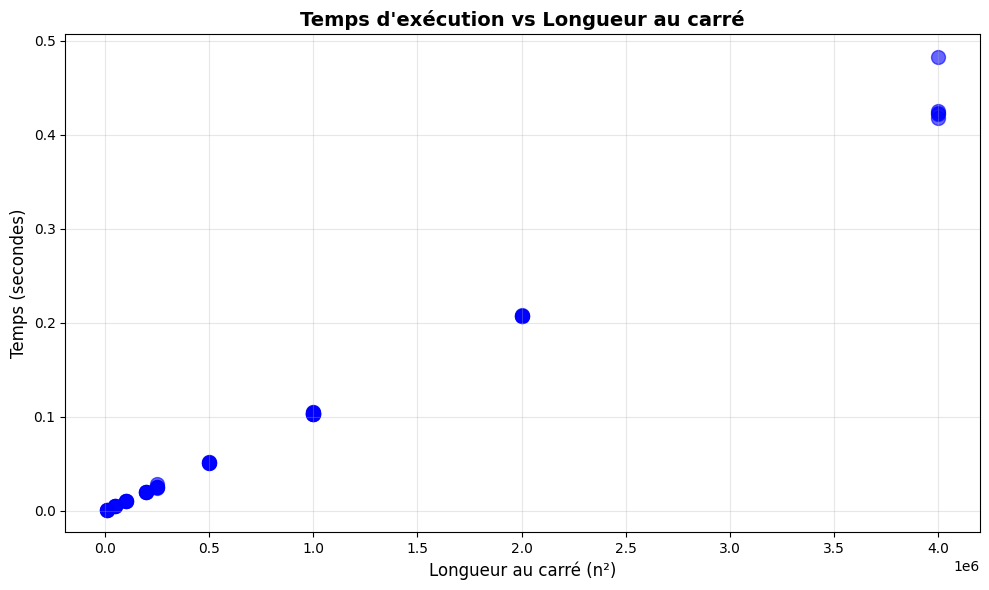

In [101]:
import matplotlib.pyplot as plt

# in our case, the pairs of random strings are always the same size, so we just need to measure the square of the string length 
#generated_dataset[‘length_squared’] = generated_dataset[‘length’] ** 2

plt.figure(figsize=(10, 6))

#Then we display the different executions according to size and time on a graph. 
plt.scatter(generated_dataset['length_(m*n)'], 
           generated_dataset['time_(s)'], 
           alpha=0.6, 
           s=100, 
           color='blue')

plt.xlabel('Longueur au carré (n²)', fontsize=12)
plt.ylabel('Temps (secondes)', fontsize=12)
plt.title('Temps d\'exécution vs Longueur au carré', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

y = 1.081161e-07 * x + -2.274659e-03
R² = 0.9959


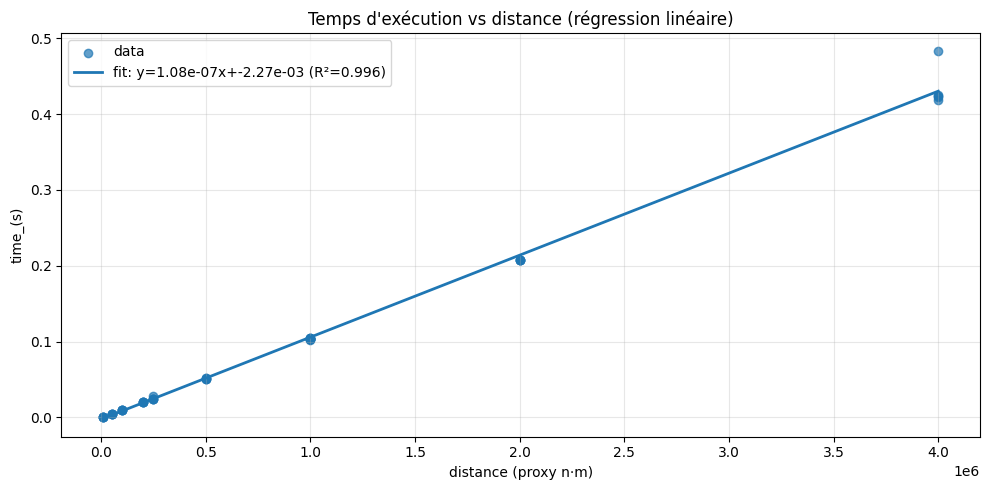

In [102]:

x = generated_dataset["length_(m*n)"].to_numpy(dtype=float)
y = generated_dataset["time_(s)"].to_numpy(dtype=float)

# Linear regression y = a*x + b (least squares) without sklearn
A = np.vstack([x, np.ones_like(x)]).T          # [x, 1]
a, b = np.linalg.lstsq(A, y, rcond=None)[0]    # slope, intercept

# Predictions + R² (to see without comparison whether our regression is close to reality (r2 being easily interpretable as it approaches 1)
y_hat = a * x + b
ss_res = np.sum((y - y_hat) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2 = 1 - ss_res / ss_tot

print(f"y = {a:.6e} * x + {b:.6e}")
print(f"R² = {r2:.4f}")

# Plot
plt.figure(figsize=(10,5))
plt.scatter(x, y, alpha=0.7, label="data")
x_line = np.linspace(x.min(), x.max(), 200)
plt.plot(x_line, a*x_line + b, linewidth=2, label=f"fit: y={a:.2e}x+{b:.2e} (R²={r2:.3f})")
plt.title("Temps d'exécution vs distance (régression linéaire)")
plt.xlabel("distance (proxy n·m)")
plt.ylabel("time_(s)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


On Observe très clairment une relation proportionnellement linéaire entre le temps de calcul du la levenshtein et la taille des trings a comparer 

### **Part 4 :  Assess the classification system:**
- Compute the global accuracy
- For each category define precision / recall / f1 score
- Build a confusion matrix
- Do you think the classification system is reliable enough ?




In [103]:
classif_df=pd.read_csv('classification dataset - ground_truth.csv')
classif_df

,product_name,real_category,prediction,Unnamed: 3,real_category.1
0,- 15 % sur les croquettes pour chat perfect fit,animalerie,animalerie,NaN,animalerie
1,[latest version]victsing(r) 5500 dpi souris ga...,high-tech,high-tech,NaN,high-tech
2,[nouveau]atoto a6 2din android car navigation ...,high-tech,high-tech,NaN,cuisine et maison
3,[nouvelle generation] xiaomi d'origine mi band...,high-tech,high-tech,NaN,auto et moto
4,* seche-serviettes electrique a inertie fluide...,cuisine et maison,cuisine et maison,NaN,epicerie
...,...,...,...,...,...
995,"xiaomi miband 4,montre connectee,tracker d'act...",high-tech,high-tech,NaN,NaN
996,"yaber booster batterie 1200a, demarreur de voi...",auto et moto,jeux video,NaN,NaN
997,yamaha eph-30 ecouteurs stereo intra-auriculai...,high-tech,high-tech,NaN,NaN
998,"zeon tech chant horloge murale, vert, 24 x 24 ...",cuisine et maison,cuisine et maison,NaN,NaN


In [63]:
#How many unique categories are there? 
classif_df['real_category'].unique()

array(['animalerie', 'high-tech', 'cuisine et maison', 'auto et moto',
       'epicerie', 'hygiene et sante', 'jeux video', 'vetements',
       'bebe et puericulture'], dtype=object)

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

#  Data 
y_true = classif_df["real_category"].astype(str)
y_pred = classif_df["prediction"].astype(str)

#  Global accuracy 
acc = accuracy_score(y_true, y_pred)
print(f"Global accuracy: {acc:.4f}")

#  Precision / Recall / F1 per class 
report = classification_report(y_true, y_pred, digits=4)
print("\nPer-class metrics (precision/recall/f1/support):\n")
print(report)


Global accuracy: 0.8450

Per-class metrics (precision/recall/f1/support):

                      precision    recall  f1-score   support

          animalerie     0.8626    0.8433    0.8528       134
        auto et moto     0.7241    0.6562    0.6885        64
bebe et puericulture     0.4583    0.8462    0.5946        13
   cuisine et maison     0.9167    0.8585    0.8866       205
            epicerie     0.9032    0.8140    0.8563       172
           high-tech     0.9310    0.9497    0.9403       199
    hygiene et sante     0.5000    0.6400    0.5614        25
          jeux video     0.0000    0.0000    0.0000        13
           vetements     0.8778    0.9029    0.8901       175

            accuracy                         0.8450      1000
           macro avg     0.6860    0.7234    0.6967      1000
        weighted avg     0.8625    0.8450    0.8520      1000



In [ ]:

# retrieve the carryover in DataFrame
report_dict = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict)
report_df



,animalerie,auto et moto,bebe et puericulture,cuisine et maison,epicerie,high-tech,hygiene et sante,jeux video,vetements,accuracy,macro avg,weighted avg
precision,0.862595,0.724138,0.458333,0.916667,0.903226,0.931034,0.500000,0.0,0.877778,0.845,0.685975,0.862549
recall,0.843284,0.656250,0.846154,0.858537,0.813953,0.949749,0.640000,0.0,0.902857,0.845,0.723420,0.845000
f1-score,0.852830,0.688525,0.594595,0.886650,0.856269,0.940299,0.561404,0.0,0.890141,0.845,0.696746,0.852045
support,134.000000,64.000000,13.000000,205.000000,172.000000,199.000000,25.000000,13.0,175.000000,0.845,1000.000000,1000.000000


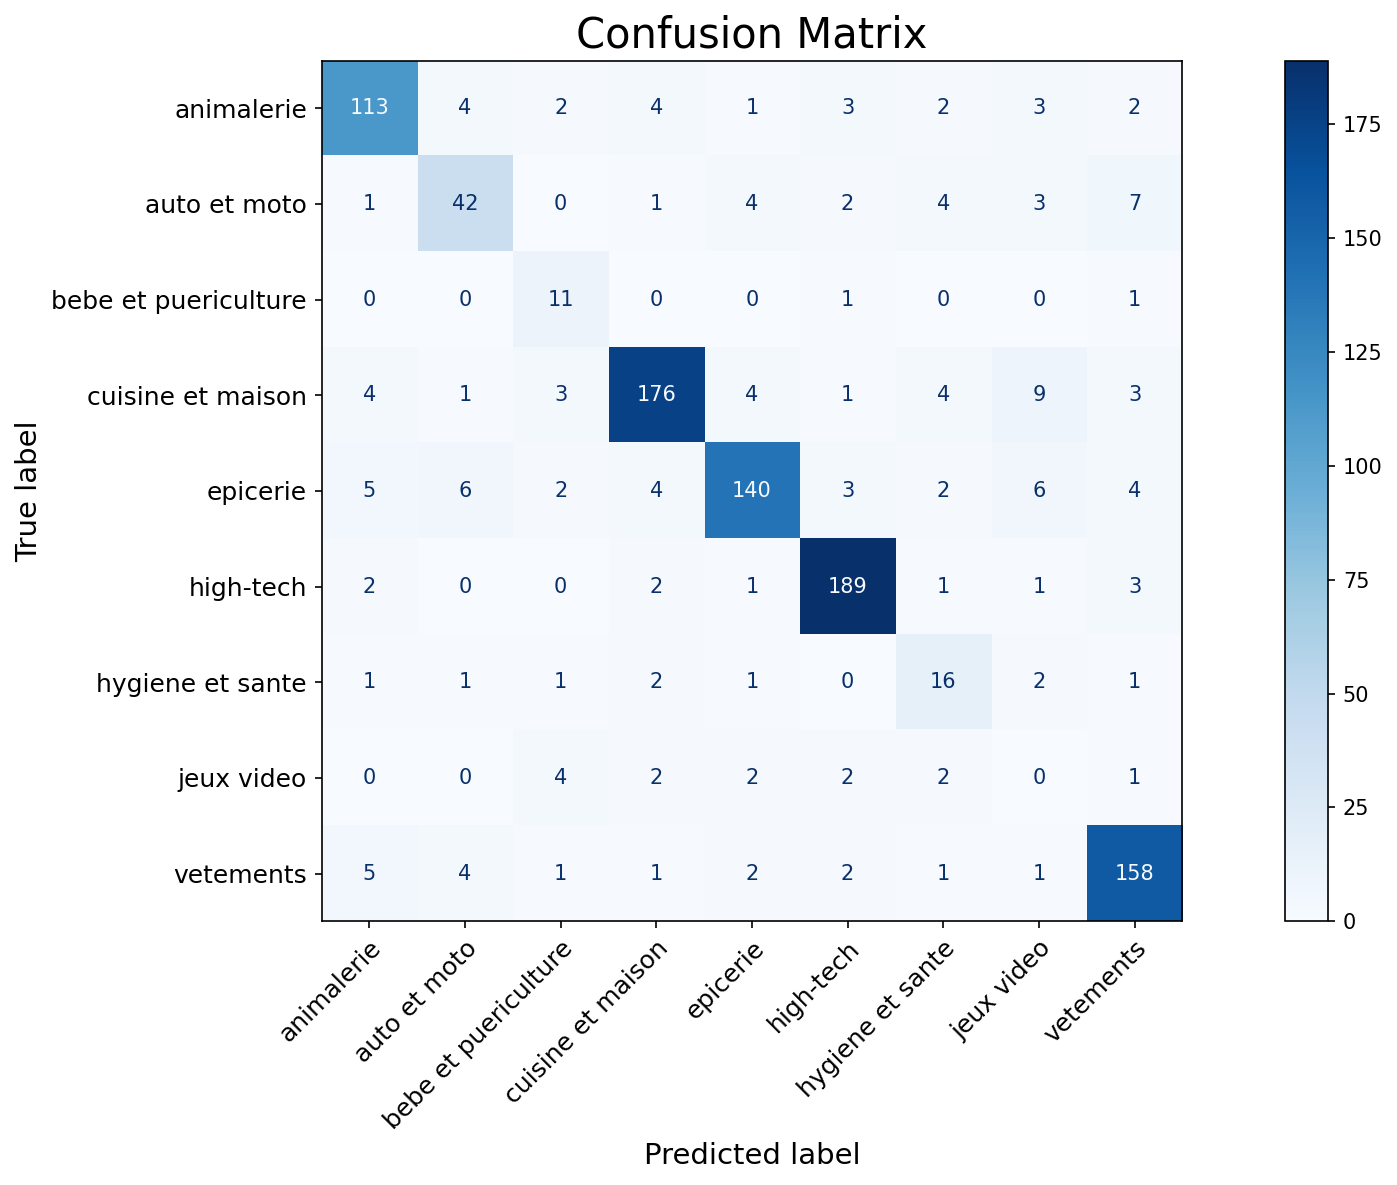

In [111]:
# We retrieve the list of all classes present (in reality + in predictions),
# then sort them to obtain a fixed order on the axes.
labels = sorted(pd.unique(pd.concat([y_true, y_pred], ignore_index=True)))

# We calculate the confusion matrix (rows = true label, columns = predicted label)
cm = confusion_matrix(y_true, y_pred, labels=labels)

# We create larger, sharper figures/axes (high dpi) to prevent overlapping.
fig, ax = plt.subplots(figsize=(14, 8), dpi=150)

# Prepare the display object and draw the matrix (displayed values, colormap + color bar)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(include_values=True, cmap="Blues", values_format="d", ax=ax, colorbar=True)

# Titles and labels of the axes
ax.set_title("Confusion Matrix", fontsize=20)
ax.set_xlabel("Predicted label", fontsize=14)
ax.set_ylabel("True label", fontsize=14)

# The labels are tilted by x so that they do not overlap.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)

# Automatically adjusts margins so that everything fits nicely
fig.tight_layout()
plt.show()




In [ ]:
# We retrieve the actual classes and the predicted classes (converted to strings to be sure).
y_true = classif_df["real_category"].astype(str)
y_pred = classif_df["prediction"].astype(str)

# We build a list of all possible classes (present in y_true or y_pred),
# then sort them to have the same order everywhere.
labels = sorted(pd.unique(pd.concat([y_true, y_pred], ignore_index=True)))
# We calculate the confusion matrix: rows = true classes, columns = predicted classes
cm = confusion_matrix(y_true, y_pred, labels=labels)

# We convert the numpy matrix into a pandas DataFrame for a more “tabular” display.
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Rename the table axis titles (just to make it clearer visually)
cm_df.index.name = 'ACTUAL'      # index = true label
cm_df.columns.name = 'PREDICTED' # columns = predicted label


cm_with_totals = cm_df.copy()# Copy the table to add a column/row of totals
cm_with_totals["Total"] = cm_with_totals.sum(axis=1)# Addition of a “Total” column = sum of each row (number of examples per true class)
cm_with_totals.loc["Total"] = cm_with_totals.sum(axis=0)# Add a “Total” row = sum of each column (number of predictions per class)
display(cm_with_totals)




PREDICTED,animalerie,auto et moto,bebe et puericulture,cuisine et maison,epicerie,high-tech,hygiene et sante,jeux video,vetements,Total
ACTUAL,,,,,,,,,,
animalerie,113,4,2,4,1,3,2,3,2,134
auto et moto,1,42,0,1,4,2,4,3,7,64
bebe et puericulture,0,0,11,0,0,1,0,0,1,13
cuisine et maison,4,1,3,176,4,1,4,9,3,205
epicerie,5,6,2,4,140,3,2,6,4,172
high-tech,2,0,0,2,1,189,1,1,3,199
hygiene et sante,1,1,1,2,1,0,16,2,1,25
jeux video,0,0,4,2,2,2,2,0,1,13
vetements,5,4,1,1,2,2,1,1,158,175


In [114]:
# Normalized version: instead of having “counts,” we use “proportions.”
# normalize="true" => each row (actual class) is divided by its total.
# Therefore, each row adds up to 1: this gives the percentage of examples from the actual class
# sent to each predicted class.
cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")

# We put this in a DataFrame for a clean display.
cm_norm_df = pd.DataFrame(cm_norm, index=labels, columns=labels)

# Names of axes to be explicit
cm_norm_df.index.name = "Actual"       # true label (lines)
cm_norm_df.columns.name = "Predicted"  # predicted label (columns)

display(cm_norm_df.round(3))# Display with 3 decimal places 



Predicted,animalerie,auto et moto,bebe et puericulture,cuisine et maison,epicerie,high-tech,hygiene et sante,jeux video,vetements
Actual,,,,,,,,,
animalerie,0.843,0.030,0.015,0.030,0.007,0.022,0.015,0.022,0.015
auto et moto,0.016,0.656,0.000,0.016,0.062,0.031,0.062,0.047,0.109
bebe et puericulture,0.000,0.000,0.846,0.000,0.000,0.077,0.000,0.000,0.077
cuisine et maison,0.020,0.005,0.015,0.859,0.020,0.005,0.020,0.044,0.015
epicerie,0.029,0.035,0.012,0.023,0.814,0.017,0.012,0.035,0.023
high-tech,0.010,0.000,0.000,0.010,0.005,0.950,0.005,0.005,0.015
hygiene et sante,0.040,0.040,0.040,0.080,0.040,0.000,0.640,0.080,0.040
jeux video,0.000,0.000,0.308,0.154,0.154,0.154,0.154,0.000,0.077
vetements,0.029,0.023,0.006,0.006,0.011,0.011,0.006,0.006,0.903


## Thanks for your courses !! see you 


Alexandro Anna et Santiago 